In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack, join
import iminuit
from iminuit import Minuit
import corner
import os
import clmm
from clmm import Cosmology
from astropy.table import Table, QTable, hstack, vstack
import pyccl as ccl
from astropy.cosmology import FlatLambdaCDM
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)

#module from my personnal github
sys.path.append('../modules/')
import analysis_Mass_Richness_relation as analysis
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import CL_fiducial_mass_richness_relation as fiducial
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import utils as ut

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [3]:
profile_true = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_SkySim5000_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl')
#profile_true=prf.load_profile(profile_name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_cosmoDC2_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl'
#                              , r_in = 'radius_av', gt_in = 'gt_av', gx_in = 'gx_av', weight = 'norm_sum',
#                          rmin = 1, rmax = 10)
lens_catalog=load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/lens_catalog_redMaPPer.pkl')

In [4]:
profile_true['gt_av'][0]

array([-232933864847105.94, 190487764161502.88, -249583643591420.34,
       -331718159017897.75, -91677366219222.28, 41815800732624.586,
       -22409583537619.785, -11660330298238.459, 37802463308586.13,
       31365370558680.617, 144453525398954.03, 163448712388534.38,
       125202582350316.17, 119458370863443.6, 71271113218500.14,
       43085346486065.17, 53952860827802.18, 47837231567451.62,
       39965351664096.82, 53501786634524.17, 6077184816777.739,
       10095020559200.943, 14856820187712.848, 17330644225703.38,
       39259541935550.01, -260461034738.2744, 6473384997073.674,
       13954508321175.367, -2065812882239.5674, 16879533284459.693],
      dtype=object)

In [5]:
profile_true = join(profile_true,lens_catalog,keys='cluster_id')

In [6]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# Fit WL mass

## Estimating shear profiles & covariances

In [7]:
profile_stack=prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness_1',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [8]:
r_corner=np.logspace(np.log10(.1), np.log10(10), 30)
shapen=prf.shape_noise_ds(profile = profile_stack,z_name = 'z_mean',
                          r_corner=r_corner, 
                          shapenoise=0.15, ns_arcmin2=25, 
                          cosmo=cosmo)

In [9]:
covariance_true_stack = prf.bootstrap_covariance(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 600,
                    z_name = 'cluster_z', obs_name = 'richness_1',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [10]:
def corr(cov):
    corr = np.zeros(cov.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            corr[i,j] = cov[i,j]/(np.sqrt(cov[i,i]*cov[j,j]))
    return corr

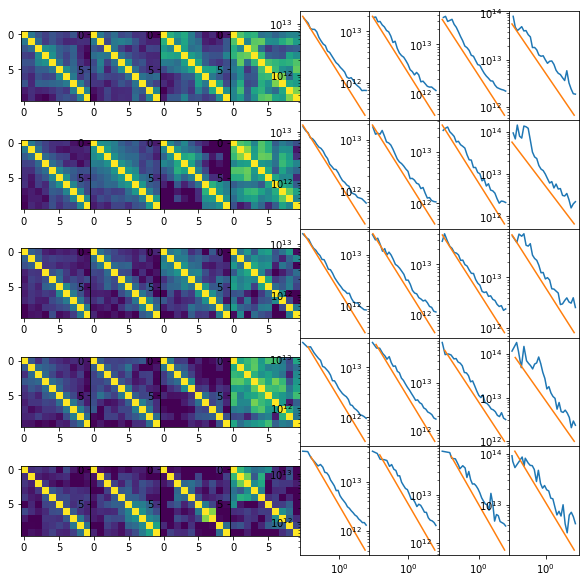

In [15]:
nz=len(Z_bin)
nobs=len(Obs_bin)
fig, ax=plt.subplots(nz, 2*nobs, figsize=(10,10),)
plt.subplots_adjust(wspace=0, hspace=0)
for i, z in enumerate(Z_bin):
    for j, obs in enumerate(Obs_bin):
        mask_z = (profile_stack['z_mean'] > z[0])*(profile_stack['z_mean'] < z[1])
        mask_m = (profile_stack['obs_mean'] > obs[0])*(profile_stack['obs_mean'] < obs[1])
        index = np.arange(len(profile_stack['z_mean']))
        index_cut = index[mask_m * mask_z][0]
        Xt = covariance_true_stack['gt_random'][index_cut]
        #for k in range(100):
        #    ax[i,j].plot(profile_stack['radius'][0], Xt[:,k], c='k')
        #    ax[i,j].set_xscale('log')
        cov=covariance_true_stack['cov_t'][index_cut]
        rmin, rmax=1, 5.5
        indexs=np.arange(len(profile_stack['radius'][0]))
        index_cuts = indexs[(profile_stack['radius'][0]>rmin)*(profile_stack['radius'][0]<rmax)]
        istart, iend=index_cuts[0], index_cuts[-1]
        
        cov_plot=np.array([np.array([cov[k,l] for l in np.arange(istart, iend)]) for k in np.arange(istart, iend)])
        ax[i,j].imshow(corr(cov_plot),vmin=0, vmax=1)
        #ax[i,j].imshow(np.corrcoef(cov_plot),vmin=0, vmax=1)
        #im = ax[i,j].imshow(np.log10(abs(covariance_true_stack['cov_t'][index_cut])), cmap='bwr')
        #plt.colorbar(im, ax=ax[i,j])
        ax[i,j+nobs].loglog(profile_stack[index_cut]['radius'], cov.diagonal()**.5)
        ax[i,j+nobs].loglog(r_corner[0:-1], shapen[index_cut]**.5)

# Fit mass-richness relation
## Fit mass then fit mass-richness relation
### Fit mass

In [12]:
down = 1
up = 5.5
a = 0
b = 1
true = fit.fit_WL_cluster_mass(profile = profile_stack, covariance = covariance_true_stack,  a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False, method='minuit', is_covariance_diagonal=False)

fitting...


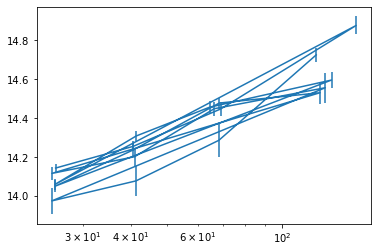

In [13]:
plt.errorbar(true['obs_mean'], true['logm200_w'], true['logm200_w_err'])
plt.xscale('log')

### Fit mass-richness relation

In [44]:
def lnL(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean):
    return mr.lnL_WL_binned(theta, m200c_mean, m200c_err_mean, richness_mean, z_mean, z0, richness0)

## Fit mass-richness relation directly

In [45]:
moo=clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)

In [46]:
def logmh(logrichness, z, logM0, alpha, beta):
    return mr.mu_logM_lambda_f(z, logrichness, logM0, alpha, beta, z0, richness0)

In [47]:
def ds(r, m, c, z):
    moo.set_mass(m), moo.set_concentration(c)
    y=moo.eval_excess_surface_density([float(r[i]) for i in range(len(r))], z)
    return y

In [48]:
def lnlikelihood(theta):
    logM0,G,F=theta
    chi2=0
    for n, halo in enumerate(profile_stack):
        m = 10**logmh(np.log10(halo['obs_mean']), halo['z_mean'], logM0, G, F)
   
        y=ds(halo['radius'], m, 4 , halo['z_mean'])
        #chi2=chi2+.5*np.sum(((y-halo['gt'])**2/covariance_true_stack[n]['cov_t'].diagonal())[mask])
        chi2=chi2+.5*np.sum((y-halo['gt'])*covariance_true_stack[n]['inv_cov_t'].dot(y-halo['gt']))
    return -chi2

In [49]:
print(lnlikelihood([14,0,1]))

AttributeError: module 'CL_Likelihood_for_Mass_richness_relation' has no attribute 'mu_logM_lambda_f'

In [ ]:
from multiprocessing import Pool
nwalker=100
pos=np.random.randn(nwalker,3) + np.array([14,0,1])
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalker, 3, lnlikelihood,pool=pool)
    sampler.run_mcmc(pos, 100, progress=True);

In [ ]:
flat_samples = sampler.get_chain(discard=50, thin=3, flat=True)
plt.rcParams['axes.linewidth'] = 1.3
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 25
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
c = ['salmon','m','k','orange','cyan']
fill_contours = [False, False, False,False,  True]
fig, axs = plt.subplots(len(labels), len(labels), figsize = (7,7))

fig = corner.corner(
flat_samples,
bins=bins, levels=(sigma1, sigma2),
fig = fig,
color = 'r',
smooth1d=True,smooth=True,plot_datapoints=False,
fill_contours=True, labels = labels,            
label_kwargs={"fontsize": 20},
use_math_text=True,
show_title = True,
plot_density=False,
max_n_ticks = 5);

fig = corner.corner(
sampler_list['true'][50000:a-1],
bins=bins, levels=(sigma1, sigma2),
fig = fig,
color = 'k',
smooth1d=True,smooth=True,plot_datapoints=False,
fill_contours=True, labels = labels,            
label_kwargs={"fontsize": 20},
use_math_text=True,
show_title = True,
plot_density=False,
max_n_ticks = 5);
    
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 13)
        axs[i,j].legend(frameon = False, fontsize = 15)

In [ ]:
mean = np.mean(flat_samples, axis=0)

In [ ]:
mean